TRAIN

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3274
           1       0.96      0.30      0.46      1183

    accuracy                           0.81      4457
   macro avg       0.88      0.65      0.67      4457
weighted avg       0.84      0.81      0.77      4457

TEST

              precision    recall  f1-score   support

           0       0.79      0.99      0.88      1085
           1       0.94      0.31      0.46       401

    accuracy                           0.81      1486
   macro avg       0.87      0.65      0.67      1486
weighted avg       0.83      0.81      0.77      1486

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1077    8
1                278  123


/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


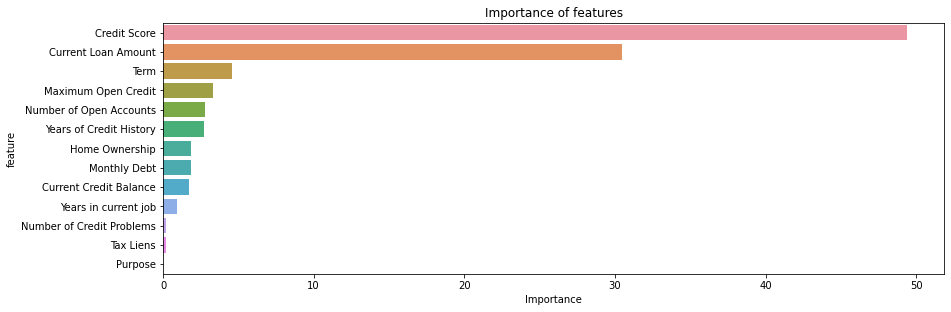

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def distribution_plot(series, label):
    """График распределения"""
    plt.figure(figsize=(16, 8))

    mean = round(series.mean(), 2)
    median = series.median()

    plt.subplot(121)
    series.hist(density=False, bins=20)
    plt.ylabel('count')
    plt.xlabel(label)

    y = np.linspace(0, 2000, 2)
    plt.plot([mean] * 2, y, label='mean', linewidth=4)
    plt.plot([median] * 2, y, label='median', linewidth=4)
    plt.legend()

    plt.subplot(122)
    sns.kdeplot(series, shade=True, legend=False)
    plt.xlabel(label)

    plt.suptitle(label)
    plt.show()
    
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        
    def fit(self, df):
        """Сохранение статистик"""
        pass
#         # Расчет медиан
#         self.medians = df[['Healthcare_1']].median()

    def fill_healthcare_nan(self, df):
        """Заполнение пропусков Healthcare_1"""
#         features = ['Ecology_1', 'Social_1', 'Shops_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'A', 'B']
#         target = 'Healthcare_1'

#         train_df = df[df['Healthcare_1'].notnull()]

#         x = train_df[features]
#         y = train_df[target]
#         model = RandomForestRegressor(max_depth=14, 
#                                       n_estimators=300,
#                                       random_state=55)
#         model.fit(x, y)

#         pred_df = df[df['Healthcare_1'].isna()][features]
#         y_pred = model.predict(pred_df)

#         df.loc[df['Healthcare_1'].isna(), target] = y_pred
        return df
        
    def transform(self, df):
        """Трансформация данных"""
        
        # Обработка категорий
#         df = pd.concat([df, pd.get_dummies(df['Ecology_2'])], axis=1)
#         df = pd.concat([df, pd.get_dummies(df['Ecology_3'])], axis=1)
#         df = pd.concat([df, pd.get_dummies(df['Shops_2'])], axis=1)
        
        # Пропуски
        df['Years in current job'].fillna(value='Not available', inplace=True)
        
#         # Healthcare_1
#         df = self.fill_healthcare_nan(df)
        
#         # По LifeSquare подобрать решение не удалось. Предсказание не показало удовлетворительный r2.
#         # У признака высокая корреляция со Square по районам.
#         df.drop(columns=['LifeSquare'], inplace=True)

#         # Исключение неиспользуемых фич
#         df.drop(columns=['Ecology_2', 'Ecology_3', 'Shops_2'], inplace=True)
        
        return df

def fit_trasform(df):
    pipe = DataPipeline()
    pipe.fit(df)
    return pipe.transform(df)

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (14, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

def make_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

    model = catb.CatBoostClassifier(n_estimators=100, max_depth=4,
                                      silent=True, random_state=21,
                                   eval_metric='F1')
    model.fit(X_train, y_train, cat_features=CAT_FEATURE_NAMES)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_pred_probs = model.predict_proba(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    
    show_feature_importances(X_train.columns, 
                                                  model.feature_importances_, 
                                                  get_top=15)

TRAIN_DATASET_PATH = 'course_project_train.csv'
df = fit_trasform(pd.read_csv(TRAIN_DATASET_PATH))

FEATURE_NAMES_TO_DROP = ['Annual Income', 'Months since last delinquent', 'Bankruptcies']
df = df.drop(FEATURE_NAMES_TO_DROP, axis=1)

TARGET_NAME = 'Credit Default'
FEATURE_NAMES_SELECTED = df.drop(TARGET_NAME, axis=1).columns

X = df.dropna()[FEATURE_NAMES_SELECTED]
y = df.dropna()[TARGET_NAME]

CAT_FEATURE_NAMES = [col for col in X.columns if len(X[col].unique()) < 5] 
CAT_FEATURE_NAMES += ['Years in current job', 'Purpose']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

make_model(X, y)

In [38]:
df.isna().sum()

Home Ownership                  0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                 1557
Credit Default                  0
dtype: int64

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.99      0.87      4047
           1       0.94      0.29      0.44      1578

    accuracy                           0.79      5625
   macro avg       0.86      0.64      0.66      5625
weighted avg       0.82      0.79      0.75      5625

TEST

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      1340
           1       0.87      0.24      0.38       535

    accuracy                           0.77      1875
   macro avg       0.82      0.61      0.62      1875
weighted avg       0.79      0.77      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1320   20
1                406  129


/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


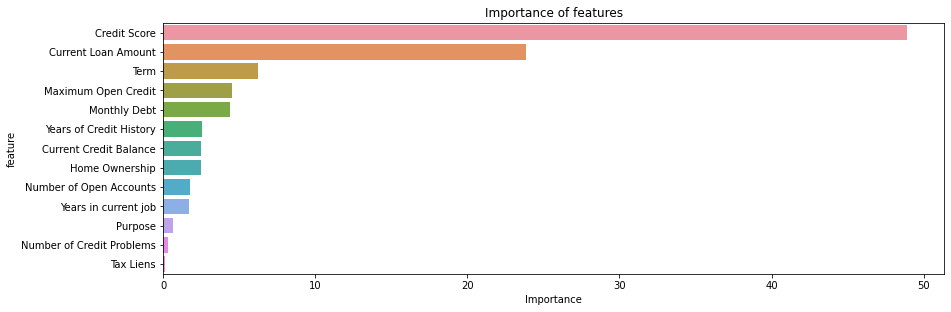

In [39]:
# - Заполнение 690
df1 = df.copy()
df1.loc[df1['Credit Score'].isna(), 'Credit Score'] = 690

X = df1.dropna()[FEATURE_NAMES_SELECTED]
y = df1.dropna()[TARGET_NAME]

CAT_FEATURE_NAMES = [col for col in X.columns if len(X[col].unique()) < 5] 
CAT_FEATURE_NAMES += ['Years in current job', 'Purpose']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

make_model(X, y)

In [71]:
# Предсказание по Current Credit Balance, Years of Credit History, Current Loan Amount, Number of Credit Problems
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

# features = ['Current Credit Balance', 'Years of Credit History', 'Current Loan Amount', 'Number of Credit Problems']
target = 'Credit Score'

def fill_credit_score_nan(df):
        """Заполнение пропусков Credit Score"""

        train_df = df[df['Credit Score'].notnull()]

        x = train_df[features]
        y = train_df[target]
        model = RandomForestRegressor(max_depth=14, 
                                      n_estimators=300,
                                      random_state=55)
        model.fit(x, y)

        pred_df = df[df['Credit Score'].isna()][features]
        y_pred = model.predict(pred_df)

        df.loc[df['Credit Score'].isna(), target] = y_pred
        return df
    
    
def check_credit_score(features, df):
    x = df[features]
    y = df[target]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    
    model = RandomForestRegressor(max_depth=7,
                             n_estimators=100,
                             random_state=55)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    r2_test = r2(y_test, y_pred)
    
    y_pred_train = model.predict(x_train)
    r2_train = r2(y_train, y_pred_train)
    
    return (r2_test, r2_train)

In [41]:
df.isna().sum()

Home Ownership                  0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                 1557
Credit Default                  0
dtype: int64

In [50]:
df.dtypes

Home Ownership                object
Years in current job         float64
Tax Liens                    float64
Number of Open Accounts      float64
Years of Credit History      float64
Maximum Open Credit          float64
Number of Credit Problems    float64
Purpose                       object
Term                          object
Current Loan Amount          float64
Current Credit Balance       float64
Monthly Debt                 float64
Credit Score                 float64
Credit Default                 int64
Have Mortgage                  uint8
Home Mortgage                  uint8
Own Home                       uint8
Rent                           uint8
dtype: object

In [47]:
df['Years in current job'].value_counts()

10.0    2332
2.0      705
3.0      620
0.5      563
5.0      516
1.0      504
4.0      469
6.0      426
7.0      396
0.0      371
8.0      339
9.0      259
Name: Years in current job, dtype: int64

In [44]:
df.loc[df['Years in current job'] == 'Not available', 'Years in current job'] = 0
df.loc[df['Years in current job'] == '< 1 year', 'Years in current job'] = 0.5
df.loc[df['Years in current job'] == '1 year', 'Years in current job'] = 1
df.loc[df['Years in current job'] == '2 years', 'Years in current job'] = 2
df.loc[df['Years in current job'] == '3 years', 'Years in current job'] = 3
df.loc[df['Years in current job'] == '4 years', 'Years in current job'] = 4
df.loc[df['Years in current job'] == '5 years', 'Years in current job'] = 5
df.loc[df['Years in current job'] == '6 years', 'Years in current job'] = 6
df.loc[df['Years in current job'] == '7 years', 'Years in current job'] = 7
df.loc[df['Years in current job'] == '8 years', 'Years in current job'] = 8
df.loc[df['Years in current job'] == '9 years', 'Years in current job'] = 9
df.loc[df['Years in current job'] == '10+ years', 'Years in current job'] = 10

In [46]:
df['Years in current job'] = df['Years in current job'].astype(float)

In [49]:
df = pd.concat([df, pd.get_dummies(df['Home Ownership'])], axis=1)

In [111]:
features_to_check = df.drop(columns=['Credit Default', 'Credit Score']).select_dtypes(include=['float64', 'int64', 'uint8'])
f_list = features_to_check.drop(['Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent'], axis=1).columns.to_list()

In [112]:
f_list

['Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt']

In [129]:
import itertools

result = {}

def combinations():
    with open('credit_score_faults.txt','w') as f:
        for L in range(0, len(f_list)+1):
            for subset in itertools.combinations(f_list, L):
                if len(subset) < 1:
                    continue
                # Check with ownage
                ownage_subset = list(subset) + ['Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent']
                r2_scores = check_credit_score(ownage_subset, df.dropna())
                s = f'{ownage_subset}, tst: {r2_scores[0]:.2f}, tr: {r2_scores[1]:.2f}'
                result[f'{r2_scores[0]}'] = s
                if (r2_scores[0] > 0.5) & (r2_scores[1] > 0.5):
                    print(f'!!! {s}')
                    os.system(f'say Found')
                else:
                    f.write(f'{r2_scores[0]:.2f}: {s}')
                    f.write('\n')


                # Check without ownage
                if len(subset) < 2:
                    continue
                r2_scores = check_credit_score(list(subset), df.dropna())
                s = f'{subset}, tst: {r2_scores[0]:.2f}, tr: {r2_scores[1]:.2f}'
                result[f'{r2_scores[0]}'] = s
                if (r2_scores[0] > 0.5) & (r2_scores[1] > 0.5):
                    print(f'!!! {s}')
                    os.system(f'say Found')
                else:
                    f.write(f'{r2_scores[0]:.2f}: {s}')
                    f.write('\n')
            
    return result


In [130]:
r = combinations()
for key in sorted(r, reverse=True):
    print ("%s: %s" % (key, r[key]))

9.409863156928377e-05: ['Maximum Open Credit', 'Number of Credit Problems', 'Current Loan Amount', 'Monthly Debt', 'Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent'], tst: 0.00, tr: 0.10
8.585416017536929e-05: ['Years in current job', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Current Loan Amount', 'Monthly Debt', 'Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent'], tst: 0.00, tr: 0.13
5.617595756157723e-05: ['Tax Liens', 'Number of Open Accounts', 'Maximum Open Credit', 'Number of Credit Problems', 'Current Credit Balance', 'Monthly Debt', 'Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent'], tst: 0.00, tr: 0.15
3.829530354315658e-05: ['Tax Liens', 'Number of Open Accounts', 'Monthly Debt', 'Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent'], tst: 0.00, tr: 0.11
1.2514811889241528e-05: ('Years in current job', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Current Loan Amount', 'Curr

In [121]:
ownage_subset = list(f_list) + ['Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent']
ownage_subset

['Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Have Mortgage',
 'Home Mortgage',
 'Own Home',
 'Rent']

In [131]:
good = [['Tax Liens', 'Number of Open Accounts', 'Maximum Open Credit', 'Current Loan Amount', 'Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent'],
['Tax Liens', 'Number of Credit Problems', 'Monthly Debt', 'Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent'],
['Tax Liens', 'Maximum Open Credit', 'Current Loan Amount', 'Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent'],
['Tax Liens', 'Number of Open Accounts', 'Maximum Open Credit', 'Number of Credit Problems', 'Current Loan Amount', 'Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent'],
['Tax Liens', 'Monthly Debt', 'Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent']]
good

[['Tax Liens',
  'Number of Open Accounts',
  'Maximum Open Credit',
  'Current Loan Amount',
  'Have Mortgage',
  'Home Mortgage',
  'Own Home',
  'Rent'],
 ['Tax Liens',
  'Number of Credit Problems',
  'Monthly Debt',
  'Have Mortgage',
  'Home Mortgage',
  'Own Home',
  'Rent'],
 ['Tax Liens',
  'Maximum Open Credit',
  'Current Loan Amount',
  'Have Mortgage',
  'Home Mortgage',
  'Own Home',
  'Rent'],
 ['Tax Liens',
  'Number of Open Accounts',
  'Maximum Open Credit',
  'Number of Credit Problems',
  'Current Loan Amount',
  'Have Mortgage',
  'Home Mortgage',
  'Own Home',
  'Rent'],
 ['Tax Liens',
  'Monthly Debt',
  'Have Mortgage',
  'Home Mortgage',
  'Own Home',
  'Rent']]

In [141]:
def deep_check_credit_score(features, df):
    x = df[features]
    y = df[target]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    
    model = RandomForestRegressor(max_depth=14,
                             n_estimators=100,
                             random_state=55)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    r2_test = r2(y_test, y_pred)
    
    y_pred_train = model.predict(x_train)
    r2_train = r2(y_train, y_pred_train)
    
    return (r2_test, r2_train)

for f in good:
    r = deep_check_credit_score(f, df.dropna())
    print(r)

(-0.013374105221641619, 0.4735679382617052)
(-0.04504596418982332, 0.3791918446933312)
(-0.011560927539200128, 0.424527576142118)
(-0.02022505816266018, 0.4717880409704316)
(-0.04204559169027222, 0.3763391391010297)


In [138]:
df1 = df.copy()
df1['Credit Score'] /= 10
df1['Credit Score'] = df1['Credit Score'].round()

df1.loc[df1['Credit Score'].between(0, 64), 'Credit Score'] = 64
df1.loc[df1['Credit Score'].between(65, 69), 'Credit Score'] = 69
df1.loc[df1['Credit Score'].between(71, 73), 'Credit Score'] = 73

df1['Credit Score'].value_counts()

73.0     2089
74.0     1530
69.0      723
75.0      697
70.0      376
         ... 
648.0       1
618.0       1
667.0       1
645.0       1
656.0       1
Name: Credit Score, Length: 116, dtype: int64

In [139]:
df1.loc[df1['Credit Score'] >= 80, 'Credit Score'] = 80
df1['Credit Score'].value_counts()

73.0    2089
74.0    1530
69.0     723
75.0     697
80.0     400
70.0     376
64.0     128
Name: Credit Score, dtype: int64

In [142]:
for f in good:
    r = deep_check_credit_score(f, df1.dropna())
    print(r)

(-0.028731420608016256, 0.6110970920813146)
(-0.03202660553322456, 0.38760043677356604)
(-0.051303240102037906, 0.5971175263329995)
(-0.02346011528034664, 0.6009951956805277)
(-0.04080113245511785, 0.3870019757986568)
